### Data Encoding & Multiclass Classification Neural Network for Attack IDS V2 - CIIC Research - José P. Areia

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

**The next blocks of code will cover all the pre-processing and data encoding done with the present dataset.**

The table below exposes the various forms of encoding done with the fields of the dataset.

| Fields                              	| Categorial Values (Dummies) 	| Empty Cells Filling 	| Z-Score Normalization 	| Standard Normalization (Value Replacing) 	| Deleted Field 	|
|-------------------------------------	|:---------------------------:	|:-------------------:	|:---------------------:	|:----------------------------------------:	|:-------------:	|
| frame.time_relative                 	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| wpan.frame_length                   	| -                           	| -                   	| &#x2714;              	| -                                        	| -             	|
| ipv6.src                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.opt.length               	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| frame.cap_len                       	| -                           	| -                   	| &#x2714;              	| -                                        	| -             	|
| udp.checksum                        	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.dstport*                        	| -                           	| -                   	| -                     	| -                                        	| -             	|
| frame.time_delta                    	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| frame.time_epoch                    	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| ipv6.dst_host                       	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.type                         	| -                           	| &#x2714;            	| -                     	| &#x2714;                                 	| -             	|
| frame.time_delta_displayed          	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| frame.protocols                     	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| udp.stream                          	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| coap.payload_length*                	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| udp.srcport*                        	| -                           	| -                   	| -                     	| -                                        	| -             	|
| wpan.seq_no                         	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.checksum.status              	| -                           	| &#x2714;            	| -                     	| -                                        	| -             	|
| 6lowpan.iphc.m                      	| -                           	| &#x2714;            	| -                     	| -                                        	| -             	|
| 6lowpan.pattern                     	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.length                          	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| frame.number                        	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| wpan.fcf                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| 6lowpan.udp.src                     	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| wpan.dst64                          	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.dio.version              	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| wpan.dst_addr_mode                  	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| 6lowpan.udp.checksum                	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| coap.opt.uri_path                   	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| icmpv6.checksum                     	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| ipv6.host                           	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.dao.sequence             	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| ipv6.addr                           	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| wpan.addr64                         	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.dio.rank                 	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| **is_malicious**                    	| -                           	| -                   	| -                     	| -                                        	| -             	|
| udp.port                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| ipv6.src_host                       	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.time_relative                   	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.pdu.size                        	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.payload                         	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| coap.opt.length                     	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| coap.type                           	| -                           	| &#x2714;            	| -                     	| &#x2714;                                 	| -             	|
| ipv6.dst                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| ipv6.plen                           	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| frame.len                           	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| icmpv6.rpl.opt.target.prefix        	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| **attack_type**                     	| -                           	| -                   	| -                     	| -                                        	| -             	|
| ipv6.nxt                            	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| 6lowpan.nhc.udp.ports               	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.opt.type                 	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| coap.payload_length                 	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| 6lowpan.iphc.nh                     	| -                           	| &#x2714;            	| -                     	| -                                        	| -             	|
| frame.time                          	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| wpan.src64                          	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| coap.opt.uri_path_recon             	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.code                         	| -                           	| &#x2714;            	| -                     	| -                                        	| -             	|
| wpan.fcs                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| icmpv6.rpl.opt.transit.pathlifetime 	| -                           	| &#x2714;            	| -                     	| &#x2714;                                 	| -             	|
| coap.mid                            	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| 6lowpan.src                         	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| coap.code                           	| &#x2714;                    	| -                   	| -                     	| -                                        	| -             	|
| icmpv6.rpl.dio.dtsn                 	| -                           	| &#x2714;            	| &#x2714;              	| -                                        	| -             	|
| 6lowpan.dst                         	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|
| udp.time_delta                      	| -                           	| -                   	| -                     	| -                                        	| &#x2714;      	|

\*The fields *udp.dstport* and *udp.srcport* have their own unique processes of encoding. <mark>Hence, the ports were later classified in different port ranges.</mark> If the a port was a well-known one it was replaced by the value of 1. Registered ports were replaced by the value 2 and the private or dynamic ports were replaced by the value of 3.

In [2]:
# Pre-processing & Data Encoding
import pandas as pd

# Import dataset
df = pd.read_csv("Datasets/Anomalous_Traffic_VF2.csv")

print(f'[DONE] Import Dataset')

[DONE] Import Dataset


In [3]:
# Delete unnecessary fields in the dataset
f_delete = [
    'frame.time_relative', 'ipv6.src', 'udp.checksum', 'frame.time_delta', 'frame.time_epoch', 
    'ipv6.dst_host', 'frame.time_delta_displayed', 'udp.stream', 'wpan.seq_no', '6lowpan.pattern',
    'frame.number', 'wpan.fcf', '6lowpan.udp.src', 'wpan.dst64', 'wpan.dst_addr_mode', '6lowpan.udp.checksum',
    'icmpv6.checksum', 'ipv6.host', 'icmpv6.rpl.dao.sequence', 'ipv6.addr', 'wpan.addr64', 'udp.port', 
    'ipv6.src_host', 'udp.time_relative', 'udp.pdu.size', 'udp.payload', 'ipv6.dst', 'icmpv6.rpl.opt.target.prefix',
    '6lowpan.nhc.udp.ports', 'coap.payload_length', 'frame.time', 'wpan.src64', 'coap.opt.uri_path_recon',
    'wpan.fcs', 'coap.mid', '6lowpan.src', '6lowpan.dst', 'udp.time_delta'
]

for i in f_delete:
    df.drop(i, axis = 1, inplace = True)

print(f'[DONE] Pre-processing & Data Encoding -- PART 01\n')
print(f'[INFO] Current Fields in the Dataset')

for i in list(df):
    print(f'- ' + i)

[DONE] Pre-processing & Data Encoding -- PART 01

[INFO] Current Fields in the Dataset
- wpan.frame_length
- icmpv6.rpl.opt.length
- frame.cap_len
- udp.dstport
- icmpv6.type
- frame.protocols
- coap.payload
- udp.srcport
- icmpv6.checksum.status
- 6lowpan.iphc.m
- udp.length
- icmpv6.rpl.dio.version
- coap.opt.uri_path
- icmpv6.rpl.dio.rank
- is_malicious
- coap.opt.length
- coap.type
- ipv6.plen
- frame.len
- attack_type
- ipv6.nxt
- icmpv6.rpl.opt.type
- 6lowpan.iphc.nh
- icmpv6.code
- icmpv6.rpl.opt.transit.pathlifetime
- coap.code
- icmpv6.rpl.dio.dtsn


In [4]:
# Fields to fill with 0
fill_fields_0 = [
    'icmpv6.type', 'icmpv6.rpl.opt.length', 'icmpv6.checksum.status', 'udp.length', 'icmpv6.rpl.dio.version',
    'icmpv6.rpl.dio.rank', 'ipv6.plen', 'frame.len', 'icmpv6.rpl.dio.dtsn'
]

# Fields to fill with -1
fill_fields_1 = [
    '6lowpan.iphc.m', 'coap.type', '6lowpan.iphc.nh', 'icmpv6.code', 'icmpv6.rpl.opt.transit.pathlifetime'
]

# Fill empty cells with n value
def fill_fields(df, fields, n):
    for i in fields:
        df[i] = df[i].fillna(n)
    return df
        
        
fill_fields(df, fill_fields_0, 0)
fill_fields(df, fill_fields_1, -1)

print(f'[DONE] Pre-processing & Data Encoding -- PART 02')

[DONE] Pre-processing & Data Encoding -- PART 02



In [5]:
from scipy.stats import zscore

# Fields to zscore normalization
zscore_fields = [
    'wpan.frame_length', 'frame.cap_len', 'icmpv6.rpl.opt.length', 'udp.length', 'icmpv6.rpl.dio.version',
    'icmpv6.rpl.dio.rank', 'ipv6.plen', 'frame.len', 'icmpv6.rpl.dio.dtsn'
]

# Zscore normalization
def zscore_normalization(df, fields):
    for i in fields:
        df[i] = zscore(df[i])
    return df

zscore_normalization(df, zscore_fields)

print(f'[DONE] Pre-processing & Data Encoding -- PART 03')

[DONE] Pre-processing & Data Encoding -- PART 03


In [6]:
# Extract the CoAP Payload length into a new column
def coap_payload_length(df):
    df[["coap.payload", "coap.payload.format", "coap.payload_length"]] = df["coap.payload"].str.split(':', expand = True)
    df["coap.payload_length"] = df["coap.payload_length"].fillna(0)
    df.drop('coap.payload', axis = 1, inplace = True)
    df.drop('coap.payload.format', axis = 1, inplace = True)
    return df

coap_payload_length(df)

print(f'[DONE] Pre-processing & Data Encoding -- PART 04')

[DONE] Pre-processing & Data Encoding -- PART 04


In [7]:
# Standard Normalization (Value Replacing)
df['icmpv6.type'] = df['icmpv6.type'].replace(155, 1)
df['coap.type'] = df['coap.type'].replace(2, 1)
df['icmpv6.rpl.opt.transit.pathlifetime'] = df['icmpv6.rpl.opt.transit.pathlifetime'].replace(30, 1)

print(f'[DONE] Pre-processing & Data Encoding -- PART 05')

[DONE] Pre-processing & Data Encoding -- PART 05


In [8]:
# Fields for dummy encode
dummy_fields = [
    'frame.protocols', 'coap.payload_length', 'coap.opt.uri_path', 'coap.opt.length', 'ipv6.nxt',
    'icmpv6.rpl.opt.type', 'coap.code'
]

# Convert fields to dummy variables
def dummy_encode(df, fields):
    for i in fields:
        df = pd.concat([df, pd.get_dummies(df[i], prefix = i)], axis = 1)
        df.drop(i, axis = 1, inplace = True)
    return df

df = dummy_encode(df, dummy_fields)

print(f'[DONE] Pre-processing & Data Encoding -- PART 06')

[DONE] Pre-processing & Data Encoding -- PART 06


In [9]:
# Classification for different ports range

# 1 - Well-Known Ports
# 2 - Registered Ports
# 3 - Private or Dynamic Ports

def src_port_range(port):
    if port['prt_src'] < 1024:
        return 1
    if port['prt_src'] < 49151:
        return 2
    if port['prt_src'] < 65535:
        return 3

def dst_port_range(port):
    if port['prt_dst'] < 1024:
        return 1
    if port['prt_dst'] < 49151:
        return 2
    if port['prt_dst'] < 65535:
        return 3

df['prt_src'] = df['udp.srcport']
df['prt_dst'] = df['udp.dstport']

df['src_port'] = df.apply (lambda row: src_port_range(row), axis = 1)
df = pd.concat([df, pd.get_dummies(df['src_port'], prefix="src_port_range")], axis = 1)
df.drop('prt_src', axis = 1, inplace = True)
df.drop('udp.srcport', axis = 1, inplace = True)
df.drop('src_port', axis = 1, inplace = True)

df['dst_port'] = df.apply (lambda row: dst_port_range(row), axis = 1)
df = pd.concat([df, pd.get_dummies(df['dst_port'], prefix = "dst_port_range")], axis = 1)
df.drop('prt_dst', axis = 1, inplace = True)
df.drop('udp.dstport', axis = 1, inplace = True)
df.drop('dst_port', axis = 1, inplace = True)

print(f'[DONE] Pre-processing & Data Encoding -- PART 07')

[DONE] Pre-processing & Data Encoding -- PART 07


In [10]:
import numpy as np

# Convert to Numpy Multiclass Classification
x_columns = df.columns.drop('is_malicious')
x = df[x_columns].values

dummies = pd.get_dummies(df['is_malicious'])
attack = dummies.columns
y = dummies.values

print(f'[DONE] Numpy Multiclass Classification')

[DONE] Numpy Multiclass Classification


In [13]:
from sklearn.model_selection import train_test_split

# Training validation splitting 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(f'[DONE] Training validation splitting')

[DONE] Training validation splitting


In [14]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Neural Network Model
model = Sequential()
model.add(Dense(50, input_dim = x.shape[1], activation = 'relu')) # Hidden 1
model.add(Dense(25, activation = 'relu')) # Hidden 2
model.add(Dense(y.shape[1], activation = 'softmax')) # Output
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(f'[DONE] Neural Network Model')

# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 10, verbose = 1, mode = 'auto', restore_best_weights = True)
model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor], verbose = 2, epochs = 1000)

print(f'[DONE] Early Stopping')

[DONE] Neural Network Model
Epoch 1/1000
15662/15662 - 22s - loss: 0.0023 - val_loss: 1.6594e-04 - 22s/epoch - 1ms/step
Epoch 2/1000
15662/15662 - 26s - loss: 1.0648e-04 - val_loss: 8.4804e-09 - 26s/epoch - 2ms/step
Epoch 3/1000
15662/15662 - 21s - loss: 1.6491e-09 - val_loss: 0.0000e+00 - 21s/epoch - 1ms/step
Epoch 4/1000
15662/15662 - 25s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 25s/epoch - 2ms/step
Epoch 5/1000
15662/15662 - 22s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 22s/epoch - 1ms/step
Epoch 6/1000
15662/15662 - 25s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 25s/epoch - 2ms/step
Epoch 7/1000
15662/15662 - 23s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 23s/epoch - 1ms/step
Epoch 8/1000
15662/15662 - 22s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 22s/epoch - 1ms/step
Epoch 9/1000
15662/15662 - 25s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 25s/epoch - 2ms/step
Epoch 10/1000
15662/15662 - 31s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 31s/epoch - 2ms/step
Epoch 11/1000
R

In [15]:
# Prediction
pred = model.predict(x_test)

5221/5221 [==============================] - 5s 1ms/step


In [16]:
from sklearn import metrics

# Metrics for the classification
def compute_metrics(pred, y_test):
    predict_classes = np.argmax(pred, axis = 1)
    expected_classes = np.argmax(y_test, axis = 1)
    
    correct = metrics.accuracy_score(expected_classes, predict_classes)
    print(f"Accuracy: {correct}")
    
    recall = metrics.recall_score(expected_classes, predict_classes, average = 'weighted')    
    print(f"Recall: {recall}")
       
    precision = metrics.precision_score(expected_classes, predict_classes, average = 'weighted')
    print(f"Precision: {precision}")
    
    f1score = metrics.f1_score(expected_classes, predict_classes, average = 'weighted')
    print(f"F1Score: {f1score}")
    
compute_metrics(pred, y_test)

Accuracy: 0.9999940139116693
Recall: 0.9999940139116693
Precision: 0.9999940139681456
F1Score: 0.99999401390128


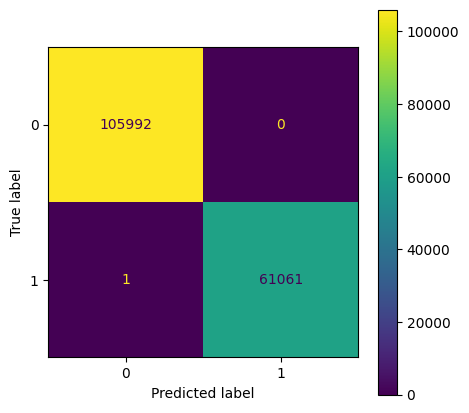

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
predict_classes = np.argmax(pred, axis = 1)
expected_classes = np.argmax(y_test, axis = 1)    
    
cm = confusion_matrix(expected_classes, predict_classes)
cmd = ConfusionMatrixDisplay(cm)

# Plot size
fig, ax = plt.subplots(figsize = (5, 5))

cmd.plot(ax = ax)

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

print(f'[DONE] Extra Trees Classifier')

[DONE] Extra Trees Classifier


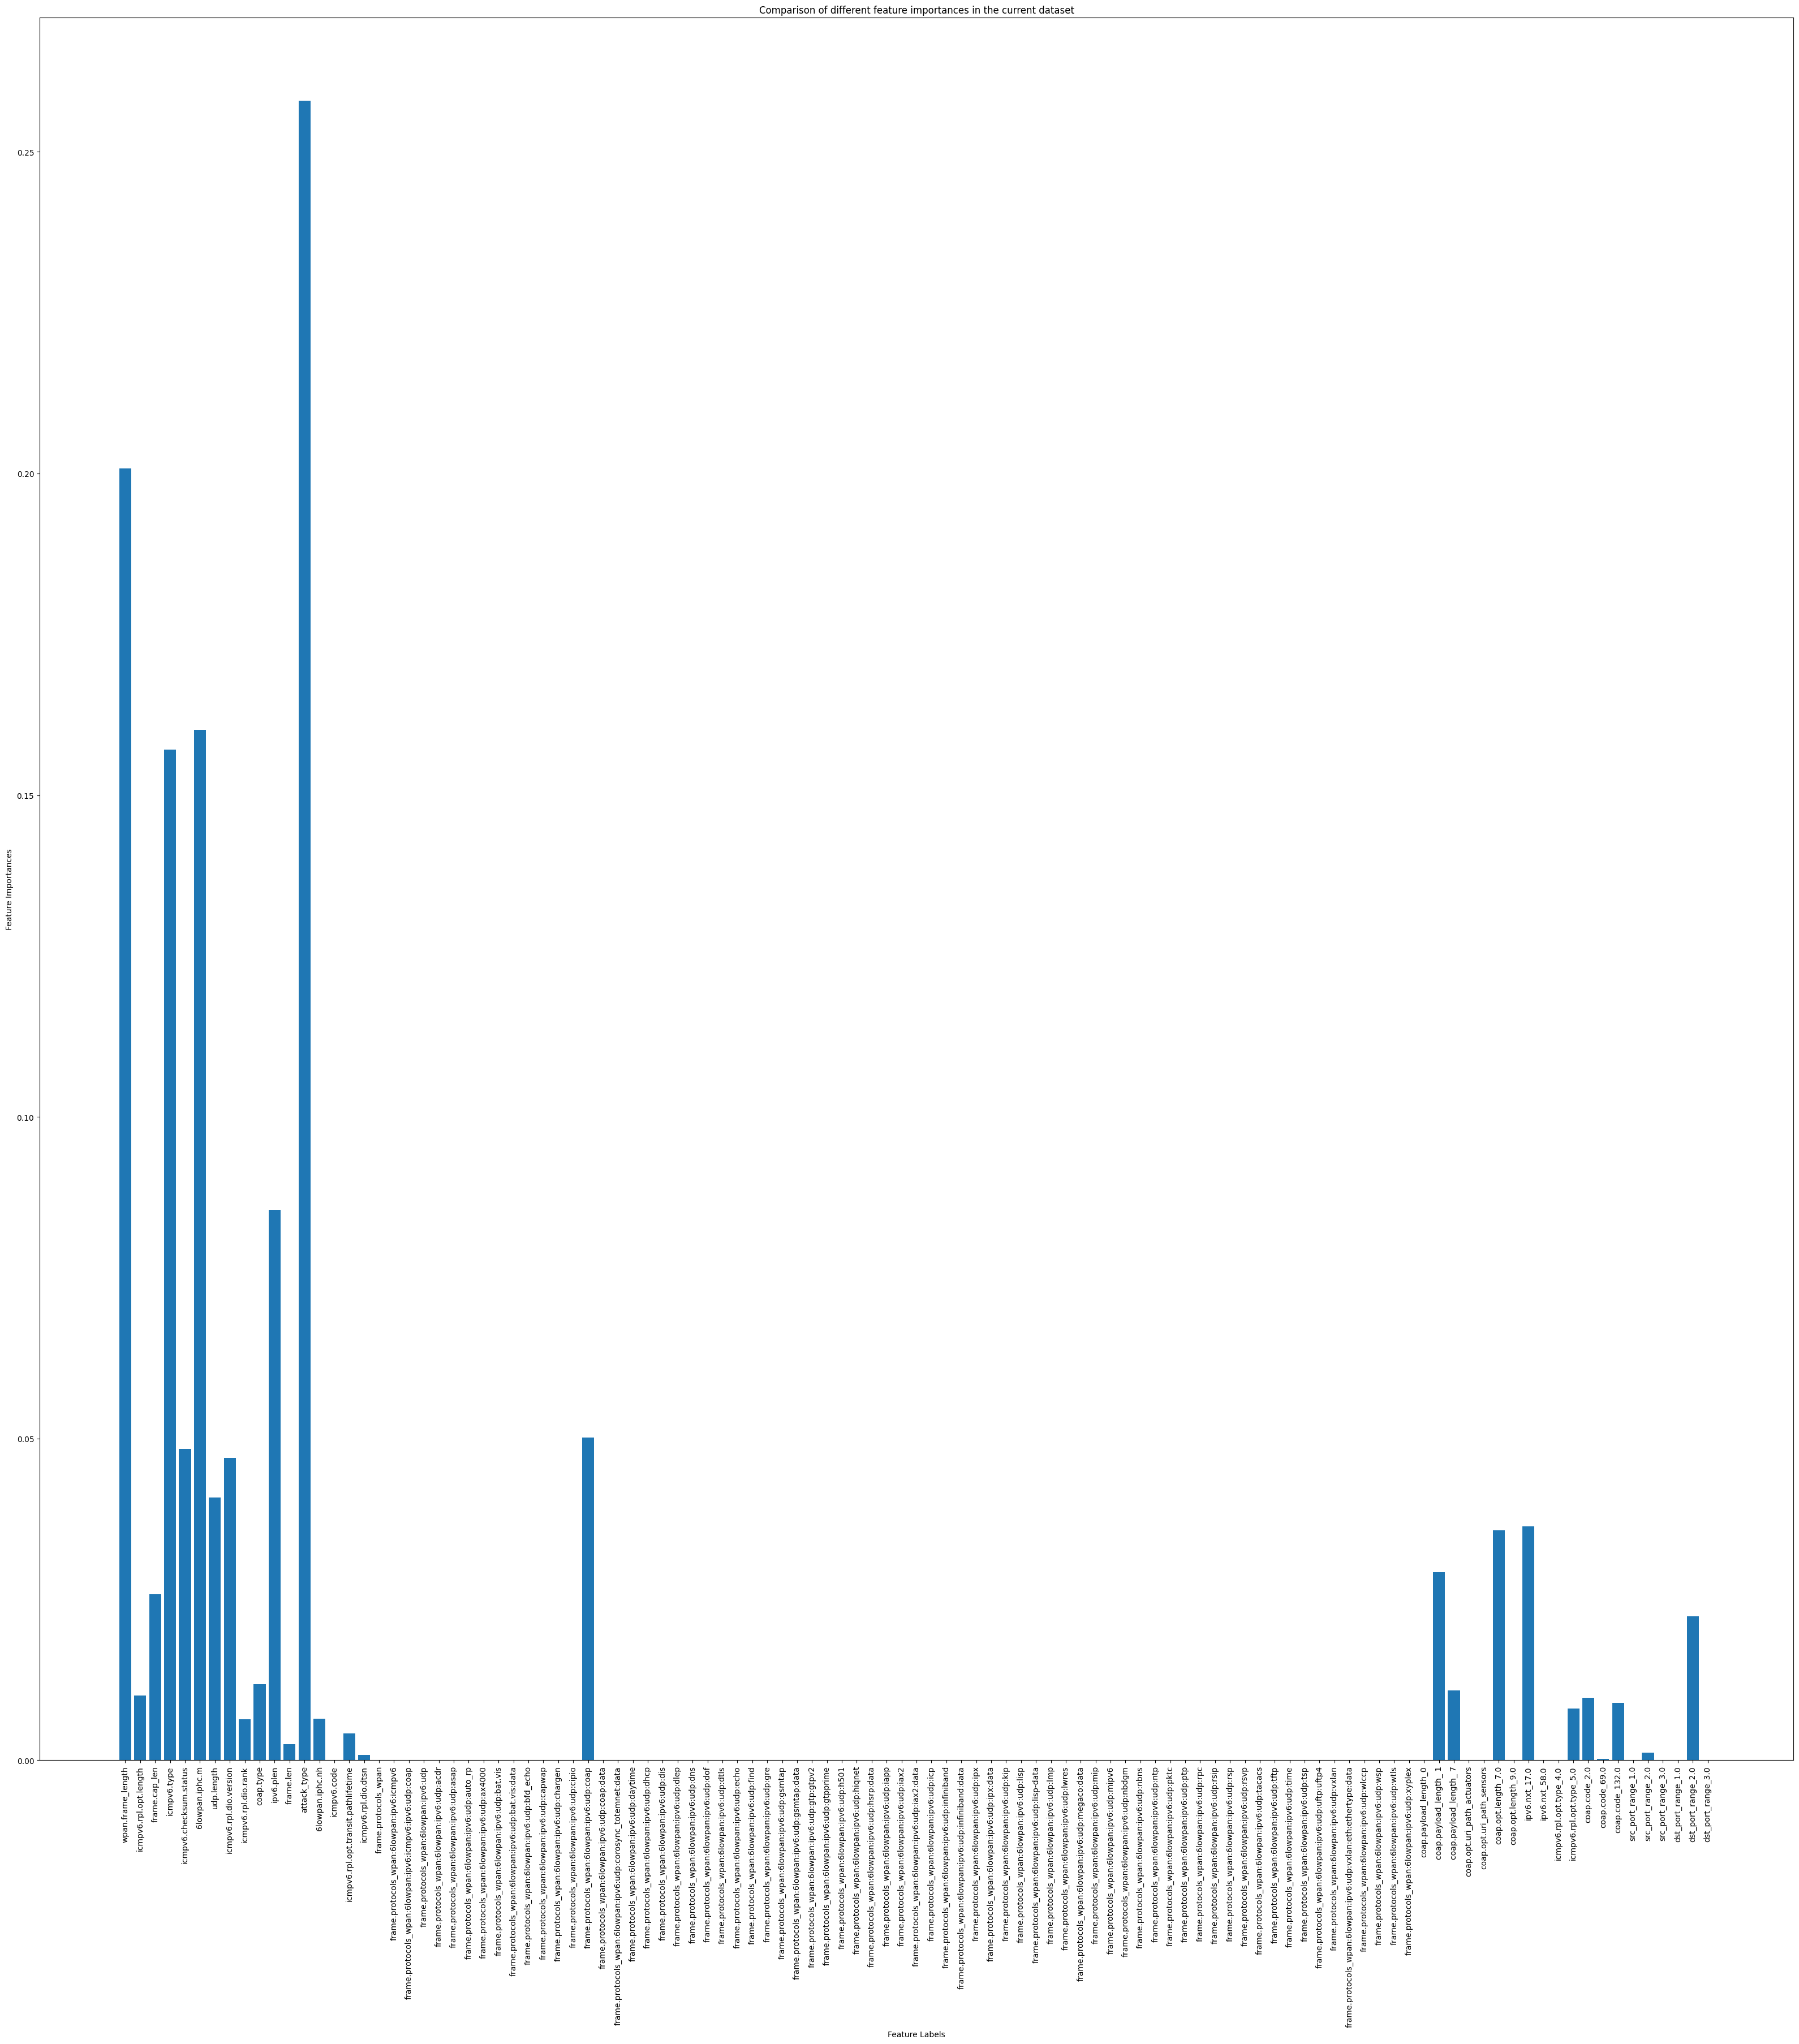

In [23]:
import matplotlib.pyplot as plot

# Plor for the ExtraTreesClassifier output
plot.bar(x_columns, feature_importance_normalized)
plot.xlabel('Feature Labels')
plot.ylabel('Feature Importances')
plot.title('Comparison of different feature importances in the current dataset')
plot.xticks(rotation = 90)

# Plot size
plot.rcParams["figure.figsize"] = (40, 40)

plot.show()